# Analyze Social Node Structure 

Perform following structural analysis

    1. Get Egonet for top 10 Social Score nodes with diameter 3 
    2. Get list of nodes visited by random walk from 
    3. Perform k-core decomposition to identify key nodes check if top 10 social score nodes are in the list 
  

In [1]:
import snap 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import csv 

from datetime import datetime
from matplotlib.pyplot import loglog 

from modifiedSocialScore import GenerateGraph, GenerateDirectedNxGraph, GeneratePrunedDirectedGraph

%matplotlib inline


Top top nodes avg response score: [(1159, 0.12607449856733524, 349.0, 44.0), (453, 0.10272536687631027, 477.0, 49.0), (1287, 0.09381663113006397, 469.0, 44.0), (1669, 0.08834355828220859, 815.0, 72.0), (1874, 0.08074866310160428, 1870.0, 151.0), (895, 0.07534246575342465, 292.0, 22.0), (1833, 0.06930693069306931, 202.0, 14.0), (1277, 0.04895104895104895, 286.0, 14.0), (1963, 0.04807692307692308, 208.0, 10.0), (350, 0.03862660944206009, 233.0, 9.0)]

 Top 10 nodes based on weighted Clique size:  [(1874, 18960.87987360233), (1258, 7167.11953894776), (999, 5016.602713704208), (511, 4383.006651884702), (1963, 3709.6503496503506), (1669, 3114.022085889569), (453, 2473.729559748429), (1287, 2238.362473347549), (1440, 2072.403038537549), (1998, 1595.1740178698046)]


In [2]:
#
# Load adjacency list as a pandas dataframe 
#
df, _ = GenerateGraph(filename='/home/merchantsameer2014/project/dnc-temporalGraph/out.dnc-temporalGraph')

In [3]:
#
# Build a networkx directed multigraph 
#   - Edge represents src sent an email to destination 
#
GNx = GenerateDirectedNxGraph(df)

In [4]:
# 
# Build an networkx undirected graph of nodes that have exchanged more than 4 emails 
#
uGNx = GeneratePrunedDirectedGraph(GNx, N=4)
#uGNx.remove_edges_from(nx.selfloop_edges(uGNx))

## Egonet analysis of top N nodes ranked based on social score... 

In [5]:
#
# Average shortest path length 
#
Gc = max(nx.connected_component_subgraphs(uGNx), key=len)
print "Average Shortest Path in email network: %r" % (nx.average_shortest_path_length(Gc))

Average Shortest Path in email network: 3.2480603654707805


In [6]:
#
# Load social score nodes 
#
socialNodes = list()
topN = 20

with open('socialScore_2.txt', 'r') as fd:
    reader = csv.reader(fd, delimiter='\t')            
    for row in reader:
        #print row
        socialNodes.append((row[0], row[1]))  
        
nodes = [ int(node) for (node, _) in socialNodes[:topN]]

In [7]:
# 
# Compute Egnonet for top 50 nodes based on Social Score 
#
egoNetworks = dict()
egoNetNodes = dict()

for index, (node, _) in enumerate(socialNodes[:topN]):
    egoNetworks[index] = nx.ego_graph(uGNx, int(node), radius=1, undirected=True)   

    #
    # Generate list of egonet Nodes for each social scode node 
    #
    egoNetNodes[index] = set(egoNetworks[index].nodes)
       

In [8]:
overlapFractions = list()
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        common_nodes = egoNetNodes[i].intersection(egoNetNodes[j])
        #print "%r(%d), %r(%d), EgoNet Nodes common: %r" % (nodes[i], len(egoNetNodes[i]),\
        #                                                 nodes[j], len(egoNetNodes[j]), len(common_nodes))
        min_nodes = min(len(egoNetNodes[i]), len(egoNetNodes[j]))
        frac = float(len(common_nodes))/float(min_nodes)
        overlapFractions.append((nodes[i],nodes[j], frac))

overlapFractions.sort(key=lambda x: (x[2], x[0], x[1]), reverse=True)

for src, dst, frac in overlapFractions:
    if (frac >= 0.5):
        print "Nodes %r, %r: overlap: %r" % (src, dst, frac)

print "\n"
for n, s in socialNodes[:topN]:
    print "Node: %r, social score: %r" % (n,s)
   

Nodes 1874, 1974: overlap: 1.0
Nodes 1874, 411: overlap: 1.0
Nodes 1258, 1974: overlap: 1.0
Nodes 1258, 411: overlap: 1.0
Nodes 999, 1974: overlap: 1.0
Nodes 999, 411: overlap: 1.0
Nodes 1874, 1963: overlap: 0.9523809523809523
Nodes 1258, 1963: overlap: 0.9523809523809523
Nodes 999, 1963: overlap: 0.9523809523809523
Nodes 511, 1974: overlap: 0.9473684210526315
Nodes 1369, 411: overlap: 0.9411764705882353
Nodes 1874, 1258: overlap: 0.925
Nodes 1998, 1522: overlap: 0.9047619047619048
Nodes 999, 1522: overlap: 0.9047619047619048
Nodes 999, 1998: overlap: 0.896551724137931
Nodes 1998, 1974: overlap: 0.8947368421052632
Nodes 1369, 1974: overlap: 0.8947368421052632
Nodes 1974, 411: overlap: 0.8823529411764706
Nodes 511, 411: overlap: 0.8823529411764706
Nodes 1874, 1522: overlap: 0.8571428571428571
Nodes 1369, 1963: overlap: 0.8571428571428571
Nodes 511, 1963: overlap: 0.8571428571428571
Nodes 585, 1974: overlap: 0.8421052631578947
Nodes 999, 511: overlap: 0.8275862068965517
Nodes 1874, 852: 

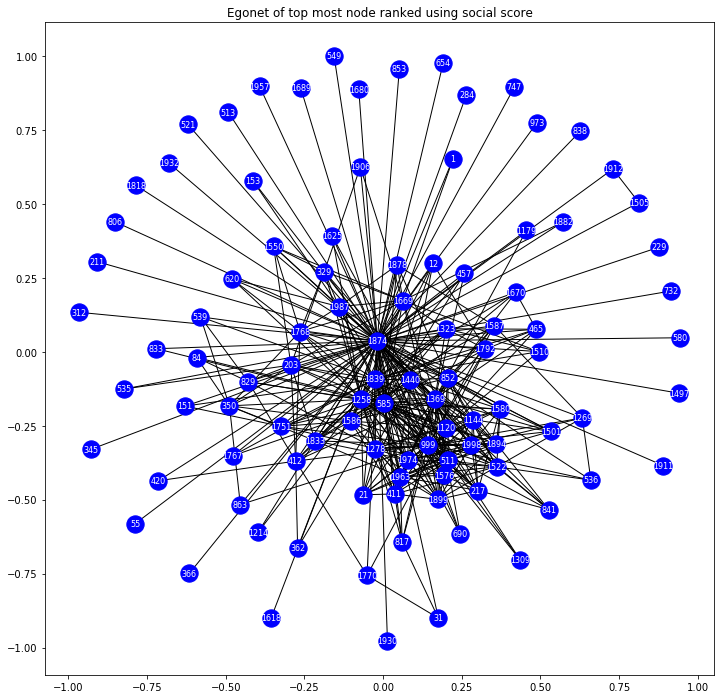

In [9]:
# Draw graph

plt.figure(figsize=(12,12))
plt.title("Egonet of top most node ranked using social score")
nx.draw_networkx(egoNetworks[0], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()



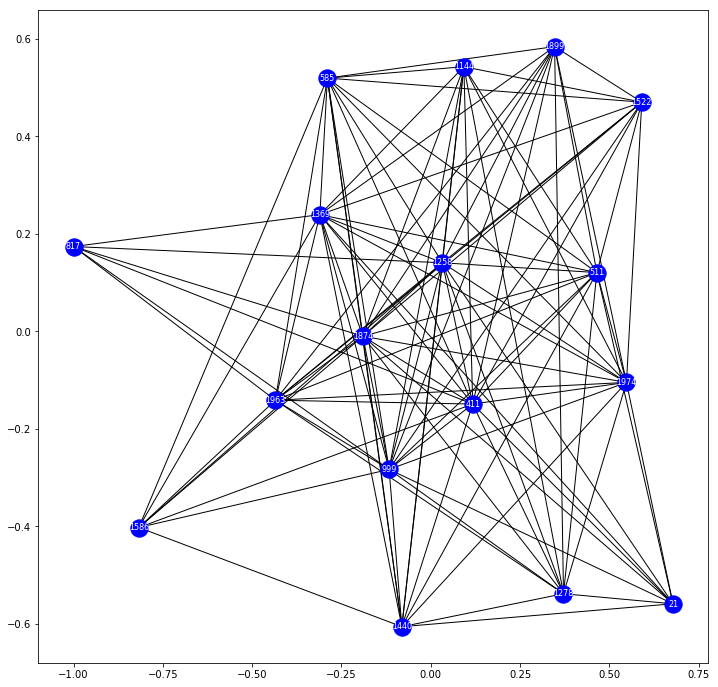

In [10]:
#
# Plot EgoNet of last node in top N Nodes ranked by social score 
#
plt.figure(figsize=(12,12))
nx.draw_networkx(egoNetworks[topN-1], node_color='b', with_labels=True, font_size=8, font_color='w')
# Draw ego as large and red
#nx.draw_networkx_nodes(egoNetworks[0], pos=nx.spring_layout(egoNetworks[0]), nodelist=[socialNodes[0][0]], node_size=400, node_color='r')
plt.show()

## k-core decomposition 

Analyze DNC email network. Identify central nodes in the network based on k-core decomposition 


Number of nodes in k=10 k-Core network: 20


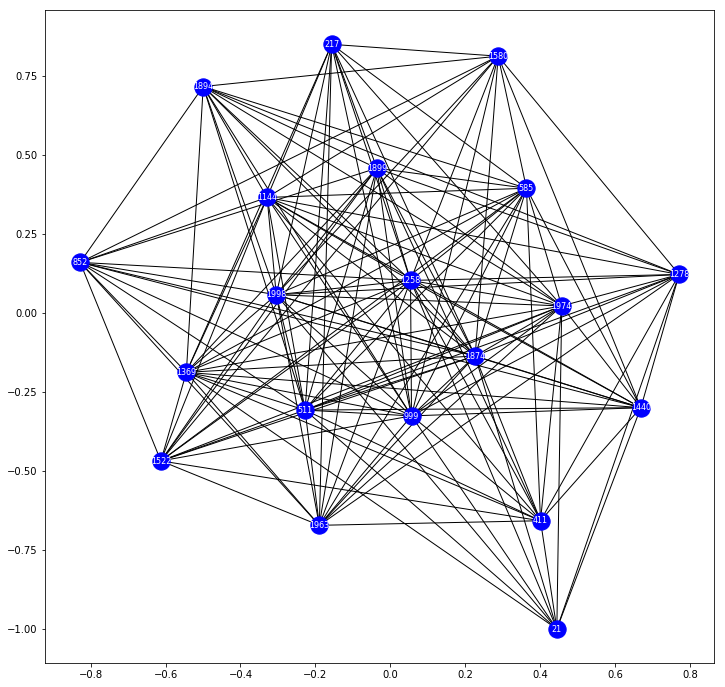

In [14]:
k = 10 
uGNx.remove_edges_from(nx.selfloop_edges(uGNx))
k_core_graph = nx.k_core(uGNx, k=k)
print "Number of nodes in k=%d k-Core network: %d" % (k, nx.number_of_nodes(k_core_graph))
plt.figure(figsize=(12,12))
nx.draw_networkx(k_core_graph, node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()

In [15]:
k_core_nodes = list(k_core_graph.nodes)
k_core_node_set = set(k_core_nodes)
tn = 20
nodes = [ int(node) for (node, _) in socialNodes[:tn]]
social_node_set = set(nodes)
#print k_core_node_set
#print social_node_set
common = social_node_set.intersection(k_core_node_set)
print "k=10 core network has total: %d nodes, %d nodes are common with top %d social nodes" % (len(k_core_nodes),\
                                                                                               len(common),\
                                                                                               tn)
print "Nodes not in k-core: %r" % (social_node_set - k_core_node_set)
print "Social nodes in k=10 core network: %r" % common

k=10 core network has total: 20 nodes, 14 nodes are common with top 20 social nodes
Nodes not in k-core: set([453, 1159, 1706, 1287, 1839, 1669])
Social nodes in k=10 core network: set([1440, 999, 585, 1258, 1963, 1522, 1998, 1874, 852, 1974, 1144, 1369, 411, 511])


In [16]:
egoNetDistribution = list()
totalEgoNetSize = 0.0
for i in range(len(nodes)):
    egoNetSize = len(list(egoNetworks[i].nodes))
    egoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    
avgEgoNetSize = totalEgoNetSize/len(nodes)
print "Average Egonet size: %r, (Max:%r, min:%r)" % (avgEgoNetSize, max(egoNetDistribution), min(egoNetDistribution))


Average Egonet size: 44.3, (Max:100, min:17)


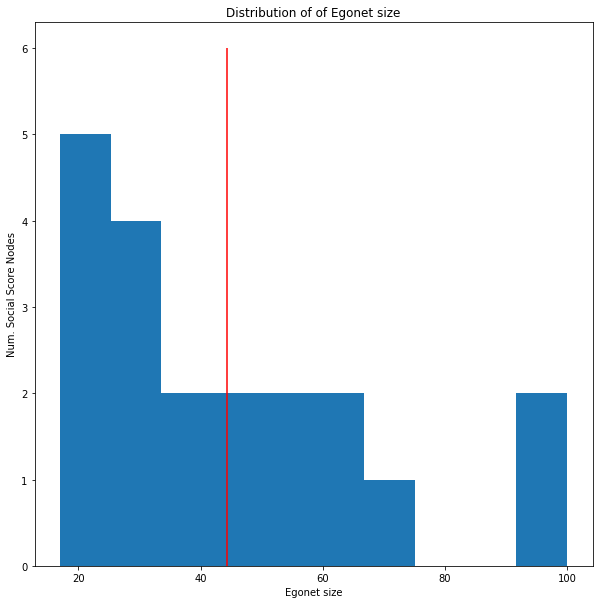

In [17]:
plt.figure(figsize=(10,10))
#plt.yscale('linear')
plt.title("Distribution of of Egonet size")
plt.xlabel('Egonet size')
plt.ylabel('Num. Social Score Nodes')
plt.vlines(avgEgoNetSize, 0, 6, color='r')
plt.hist(egoNetDistribution)
plt.show()

# CELF Node analysis

In [18]:
celfNodes = [ 453, 246, 1952, 1144, 1701, 547, 1377, 1907, 278, 1889, 1874, 1953, 115, 1966, 795, 1803, 1805, 2014, 1287, 798 ]                                     
celfNodeSet = set(celfNodes)

In [19]:
celfNodesInKCore = celfNodeSet.intersection(k_core_node_set)
celfNodeInSocialNodes = celfNodeSet.intersection(social_node_set)

In [20]:
print "CELF nodes in k-core k=10 %r" % celfNodesInKCore
print "CELF nodes in top N nodes ranked by social score %r" % celfNodeInSocialNodes

CELF nodes in k-core k=10 set([1144, 1874])
CELF nodes in top N nodes ranked by social score set([1144, 1874, 453, 1287])


## Betweeness centrality

Node 1907 not found in pruned Graph!
Node 795 not found in pruned Graph!
Node 1803 not found in pruned Graph!
Node 1805 not found in pruned Graph!
Node 2014 not found in pruned Graph!
Average Betweeness Centrality of nodes selected by CELF: 0.029221988460512067


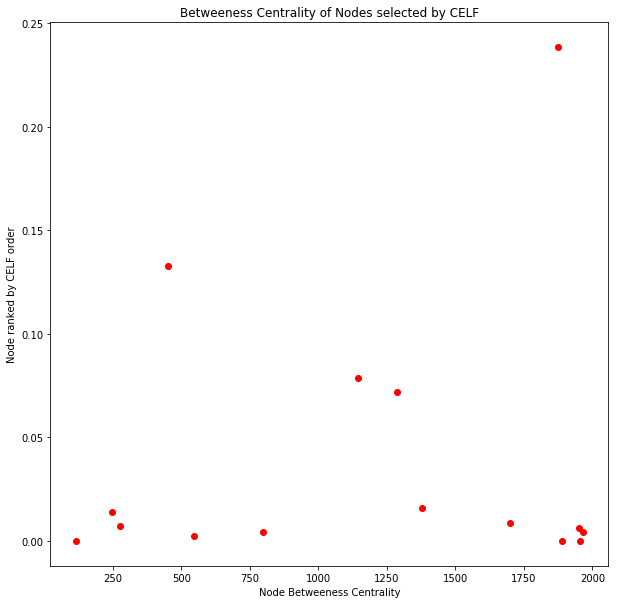

In [21]:
node_between_centrality = nx.betweenness_centrality(uGNx)
celfNodeBetweenCentrality = list()

totalCelfNodeBetweenCentrality = 0.0

y = list()
for n in celfNodes:   
    b = node_between_centrality.get(n, None)
    
    if b == None:
        print "Node %r not found in pruned Graph!" % n
        continue
        
    celfNodeBetweenCentrality.append(b)
    totalCelfNodeBetweenCentrality += b
    y.append(n)
    
avgCelfNodeBetweenCentrality = totalCelfNodeBetweenCentrality/len(celfNodes)  
print "Average Betweeness Centrality of nodes selected by CELF: %r" % avgCelfNodeBetweenCentrality

plt.figure(figsize=(10,10))
plt.title("Betweeness Centrality of Nodes selected by CELF")
plt.xlabel("Node Betweeness Centrality")
plt.ylabel("Node ranked by CELF order")
plt.plot(y, celfNodeBetweenCentrality, 'ro')
plt.show()

Average Betweeness Centrality of nodes selected ranked by Social Score: 0.07059158151476777


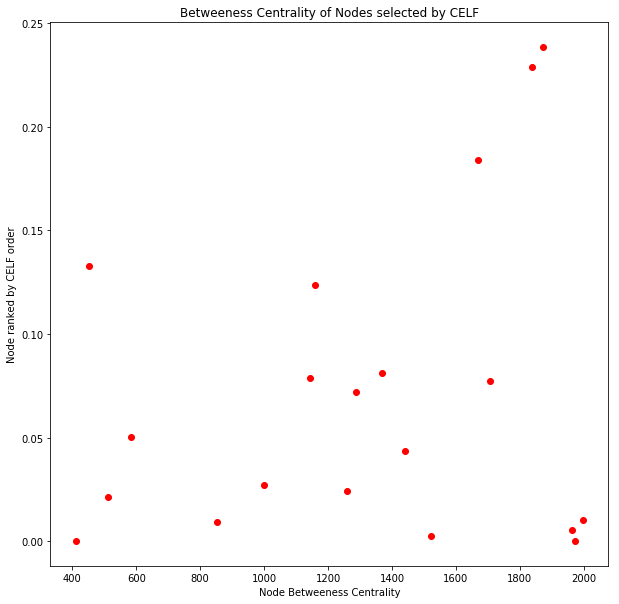

In [22]:
node_between_centrality = nx.betweenness_centrality(uGNx)
socialNodeBetweenCentrality = list()

totalSocialNodeBetweenCentrality = 0.0

y = list()
for n in nodes:   
    b = node_between_centrality.get(n, None)
    
    if b == None:
        print "Node %r not found in undirected Graph!" % n
        continue
        
    socialNodeBetweenCentrality.append(b)
    totalSocialNodeBetweenCentrality += b
    y.append(n)
    
avgSocialNodeBetweenCentrality = totalSocialNodeBetweenCentrality/len(celfNodes)  
print "Average Betweeness Centrality of nodes selected ranked by Social Score: %r" % avgSocialNodeBetweenCentrality

plt.figure(figsize=(10,10))
plt.title("Betweeness Centrality of Nodes selected by CELF")
plt.xlabel("Node Betweeness Centrality")
plt.ylabel("Node ranked by CELF order")
plt.plot(y, socialNodeBetweenCentrality, 'ro')
plt.show()

39264
1103
1891
452


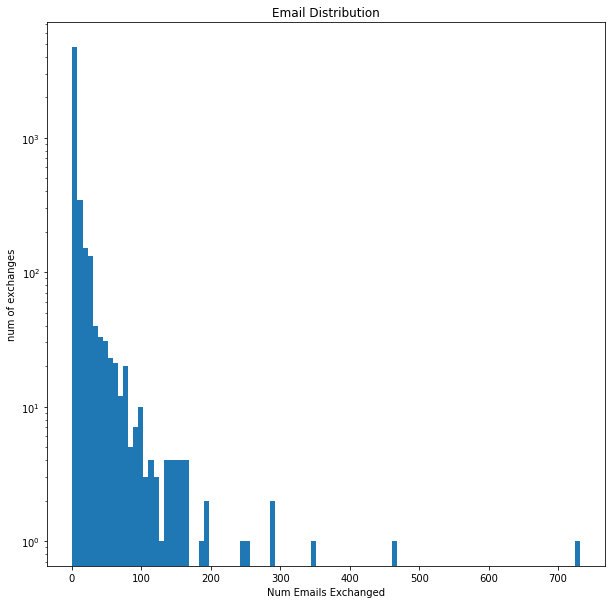

In [23]:
print GNx.number_of_edges()
print uGNx.number_of_edges()
print GNx.number_of_nodes()
print uGNx.number_of_nodes()

edgeCount = dict()
for edge in GNx.edges():
    if not edgeCount.get(edge, None):
        edgeCount[edge] = 0
    edgeCount[edge] += 1 
        
emailDist= [ v for k, v in edgeCount.iteritems() ]
emailDist.sort(reverse=True)

plt.figure(figsize=(10,10))
plt.title("Email Distribution")
plt.xlabel("Num Emails Exchanged")
plt.ylabel("num of exchanges")
plt.yscale('log')
plt.hist(emailDist,bins=100)
plt.show()


In [24]:
# 
#  Egnonet of nodes picked by CELF
#
egoNetworks = dict()
egoNetNodes = dict()

for index, node in enumerate(celfNodes):
    if not uGNx.has_node(node):
        continue
        
    egoNetworks[node] = nx.ego_graph(uGNx, int(node), radius=1, undirected=True)   

    #
    # Generate list of egonet Nodes for each social scode node 
    #
    egoNetNodes[node] = set(egoNetworks[node].nodes)
       

Average Egonet size: 19.866666666666667, (Max:98, min:1)


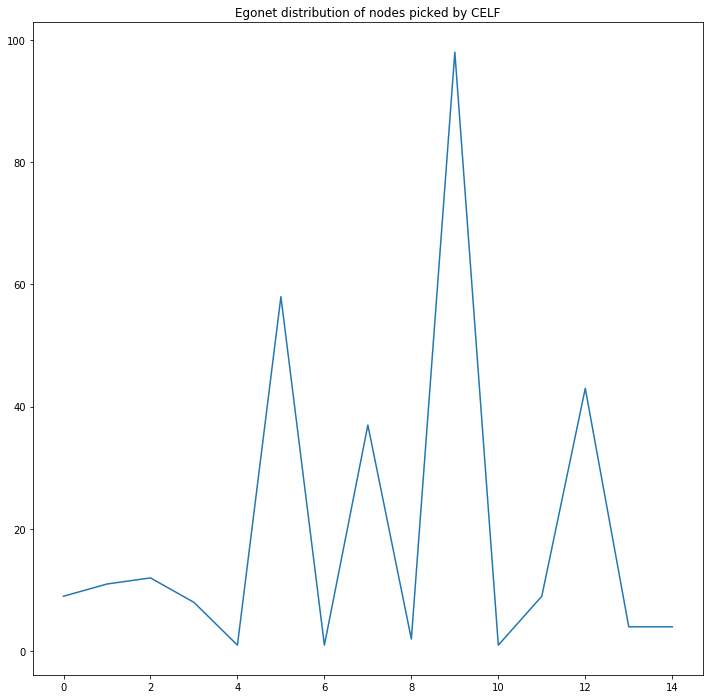

In [25]:
egoNetDistribution = list()
egoNetTuple = list()
totalEgoNetSize = 0.0
for node in egoNetworks.keys():
    egoNetSize = egoNetworks[node].number_of_nodes() - 1
    egoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    egoNetTuple.append((node, egoNetSize))
    
avgEgoNetSize = totalEgoNetSize/len(egoNetworks)
print "Average Egonet size: %r, (Max:%r, min:%r)" % (avgEgoNetSize, max(egoNetDistribution), min(egoNetDistribution))


plt.figure(figsize=(12,12))
plt.title("Egonet distribution of nodes picked by CELF")
plt.plot(egoNetDistribution)
plt.show()

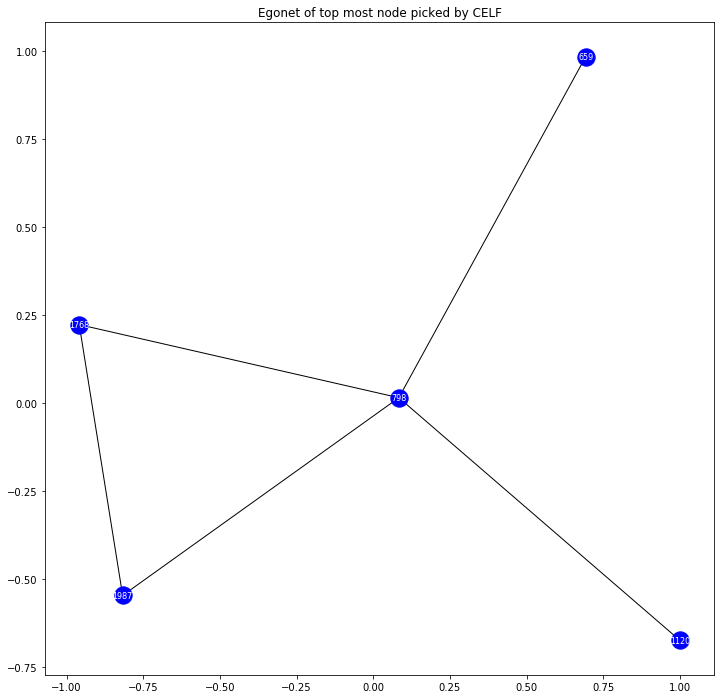

5


In [27]:
# Draw graph

plt.figure(figsize=(12,12))
plt.title("Egonet of top most node picked by CELF")
nx.draw_networkx(egoNetworks[798], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()
print egoNetworks[798].number_of_edges()


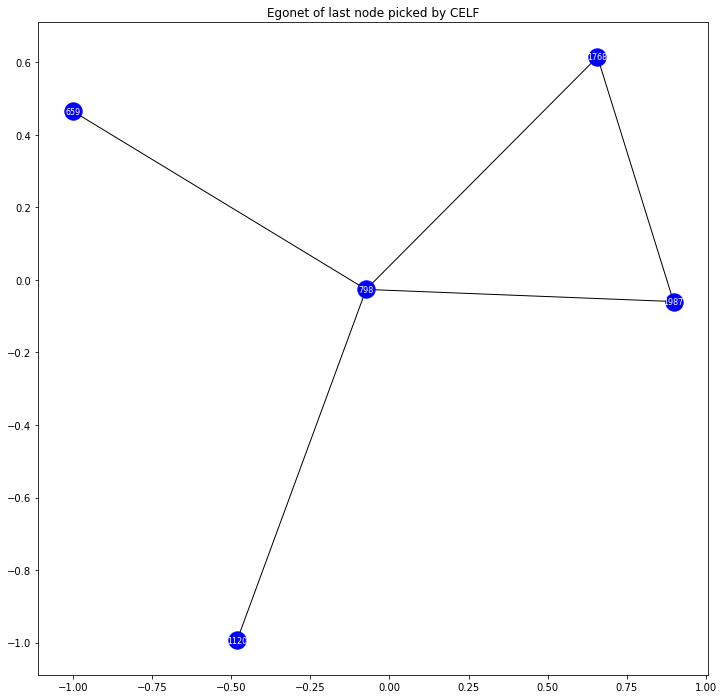

In [158]:
plt.figure(figsize=(12,12))
plt.title("Egonet of last node picked by CELF")
nx.draw_networkx(egoNetworks[798], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()


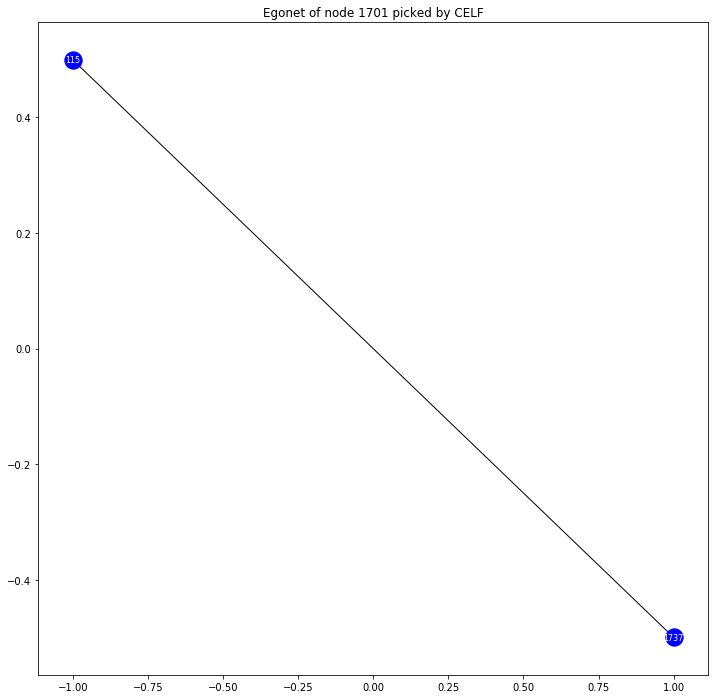

2


In [159]:
plt.figure(figsize=(12,12))
plt.title("Egonet of node 1701 picked by CELF")
nx.draw_networkx(egoNetworks[115], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()
print egoNetworks[115].number_of_nodes()

In [160]:
print egoNetTuple

[(1952, 9), (1377, 11), (278, 12), (547, 8), (1953, 1), (453, 58), (1889, 1), (1287, 37), (1966, 2), (1874, 98), (115, 1), (246, 9), (1144, 43), (798, 4), (1701, 4)]


In [165]:
GNx.degree(1889)

466

In [180]:
x = [1874, 1258, 1669, 999, 511, 852, 585, 1440, 1998, 1278, 1580, 1974, 411, 453, 1159, 1894, 1369, 1839, 1522, 737, 1706, 1144    
, 1287, 1963 ]
#x = [1874, 1258, 1669, 999, 511, 852, 585, 1440, 1998, 1278, 1580, 1974, 411, 453, 1159, 1894, 1369, 1839, 1522, 737]
x_set = set(x)
social_set = set([ int(node) for (node, _) in socialNodes[:24]])
y = x_set.intersection(social_set)
print len(y), len(social_set), len(x_set)
print x_set - y
print social_node_set.intersection(celfNodeSet)
print x_set.intersection(celfNodeSet)

22 24 24
set([737, 1580])
set([1144, 1874, 453, 1287])
set([1144, 1874, 453, 1287])


In [166]:
#
# Get Degree Distribution 
# 
OutDegToCntV = snap.TIntPrV()
snap.GetOutDegCnt(G, OutDegToCntV)
count = 0
nodeList = []
degreeList = []
for item in OutDegToCntV:
    (n, d) = (item.GetVal2(), item.GetVal1())
    nodeList.append(n)
    degreeList.append(d)
x = np.array( [ np.log10(item.GetVal1()) for itemm in OutDegToCntV if item.GetVal1() > 0 ] )
y = np.array( [ np.log10(item.GetVal2()) for item in OutDegToCntV if item.GetVal2() > 0 ] )
#
# Plot Degree Distribution
#
plt.figure(figsize=(15,15))
loglog(degreeList, nodeList, 'bo')
#plt.plot(x_plot, 10**b*x_plot**a, 'r-')
plt.title("LogLog plot of out-degree distribution")
plt.show()

NameError: name 'G' is not defined